In [1]:
PATH = '/Users/siddhantthakur/pizza req/'

from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from statistics import mean
from prettytable import PrettyTable

import matplotlib.pyplot as plt
import shap

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

np.set_printoptions(suppress=True)

In [2]:
# certificate verification fail

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
with open(PATH + 'pizza_request_dataset/pizza_request_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
len(data)

5671

In [6]:
sorted(data[0].keys())

['giver_username_if_known',
 'in_test_set',
 'number_of_downvotes_of_request_at_retrieval',
 'number_of_upvotes_of_request_at_retrieval',
 'post_was_edited',
 'request_id',
 'request_number_of_comments_at_retrieval',
 'request_text',
 'request_text_edit_aware',
 'request_title',
 'requester_account_age_in_days_at_request',
 'requester_account_age_in_days_at_retrieval',
 'requester_days_since_first_post_on_raop_at_request',
 'requester_days_since_first_post_on_raop_at_retrieval',
 'requester_number_of_comments_at_request',
 'requester_number_of_comments_at_retrieval',
 'requester_number_of_comments_in_raop_at_request',
 'requester_number_of_comments_in_raop_at_retrieval',
 'requester_number_of_posts_at_request',
 'requester_number_of_posts_at_retrieval',
 'requester_number_of_posts_on_raop_at_request',
 'requester_number_of_posts_on_raop_at_retrieval',
 'requester_number_of_subreddits_at_request',
 'requester_received_pizza',
 'requester_subreddits_at_request',
 'requester_upvotes_minus

In [7]:
success = [d['requester_received_pizza'] for d in data]
print("Average Success Rate",str(sum(success)/len(success)*100))

Average Success Rate 24.634103332745546


In [8]:
for d in data:
    d['upvotes_minus_downvotes'] = d['number_of_upvotes_of_request_at_retrieval'] - d['number_of_downvotes_of_request_at_retrieval']

for d in data:
    d['final_request_text'] = d['request_title'] + " " + d['request_text_edit_aware']

In [9]:
data[0]

{'giver_username_if_known': 'N/A',
 'in_test_set': False,
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 6,
 'post_was_edited': False,
 'request_id': 't3_w5491',
 'request_number_of_comments_at_retrieval': 7,
 'request_text': "I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.\n\nI've got a few bucks to get on the bus to work on Saturday, so I can't really use that.\n\nI'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.\n\nI guess tha

In [10]:
df = pd.json_normalize(data)
df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,upvotes_minus_downvotes,final_request_text
0,verygoodname,False,0,3,False,t3_sp8xg,6,"Any help would be appreciated, and reciprocate...","Any help would be appreciated, and reciprocate...","[Request] Broke and hungry in Kentucky, would ...",...,164,782,216,1256,PIF,CaptBeeFart,1.335237e+09,1.335233e+09,3,"[Request] Broke and hungry in Kentucky, would ..."
1,N/A,False,5,6,False,t3_x3zw7,1,FORGOT TO PUT LOCATION - RHODE ISLAND\n\nSo th...,FORGOT TO PUT LOCATION - RHODE ISLAND\n\nSo th...,[REQUEST] No food until the second... pizza ge...,...,0,10,0,32,None,Kitsuneominous,1.343189e+09,1.343185e+09,1,[REQUEST] No food until the second... pizza ge...
2,N/A,False,2,2,False,t3_1arvbn,0,Anyone feeling kind enough to hand out a stuff...,Anyone feeling kind enough to hand out a stuff...,"[Request] Just got new job, really would like ...",...,7970,9276,15414,18534,None,superthrust,1.363921e+09,1.363917e+09,0,"[Request] Just got new job, really would like ..."
3,N/A,False,0,2,False,t3_jwild,4,Stuck at UMW where we're currently on lockdown...,Stuck at UMW where we're currently on lockdown...,"[Request] My dorm is on lockdown, and I'm goin...",...,5,8,47,50,None,luhhhren,1.314490e+09,1.314487e+09,2,"[Request] My dorm is on lockdown, and I'm goin..."
4,N/A,False,2,4,False,t3_1mm4im,0,"Hey guys, long time lurker who wishes she coul...","Hey guys, long time lurker who wishes she coul...","[Request] Starving in Orlando, no money til to...",...,13,16,23,32,None,leangle,1.379472e+09,1.379469e+09,2,"[Request] Starving in Orlando, no money til to..."


In [11]:
df['requester_received_pizza'].isna().sum()

0

In [12]:
# text preprocessing
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.replace("\n"," ").replace("\r"," ")
    text = re.sub(r'“', " '' ", text)
    text = re.sub(r'”', " '' ", text)
    text = re.sub(r'"', " '' ", text)
    text = re.sub(r'(\S)(\'\')', r'\1 \2 ', text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    punc_list = '!"#$%()*+,-./:;<=>?@^_{|}~[]'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)
    
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    
    text = text.lower()
    
    tokens = regexp_tokenize(text,pattern='\s+',gaps=True)
    cleaned_tokens = []
    
    for t in tokens:
        if t not in stopwords_eng:
            l = lemmatizer.lemmatize(t)
            cleaned_tokens.append(l)
    
    return cleaned_tokens

In [13]:
process_text(df['final_request_text'][0])

['request',
 'broke',
 'hungry',
 'kentucky',
 'would',
 'love',
 'pizza',
 'right',
 'help',
 'would',
 'appreciated',
 'reciprocated',
 'get',
 'paid',
 '2',
 'week']

In [14]:
# 20% split for train and test data
train_set = df.loc[:4536,:]
test_set = df.loc[4537:,:].reset_index(drop=True)
print(train_set.shape)
print(test_set.shape)

(4537, 35)
(1134, 35)


In [15]:
final_df = df.loc[:,['upvotes_minus_downvotes','requester_account_age_in_days_at_request','request_number_of_comments_at_retrieval']]
final_df['length_of_text'] = df.apply(lambda r: len(r['final_request_text']), axis = 1)
final_df['evidence_link'] = df.apply(lambda r: 1 if re.findall(r'(?:http\:|https\:)?\/\/.*\.',r['final_request_text']) else 0, axis = 1)
final_df['requester_posted_before'] = df.apply(lambda r: 0 if r['requester_days_since_first_post_on_raop_at_request']==0 else 1, axis = 1)
final_df['requester_received_pizza'] = df.loc[:,'requester_received_pizza']

final_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,3,238.726840,6,145,0,0,1
1,1,0.000000,1,901,1,0,0
2,0,1250.097998,0,179,0,0,0
3,2,171.035521,4,260,0,0,0
4,2,466.100787,0,393,0,0,0
...,...,...,...,...,...,...,...
5666,1,0.000000,3,222,0,0,0
5667,0,78.204560,0,475,0,0,0
5668,3,75.020139,9,1211,0,0,1
5669,6,330.132280,6,551,0,0,0


In [16]:
final_train_set = final_df.loc[:4536,:]
final_test_set = final_df.loc[4537:,:].reset_index(drop=True)
print(final_train_set.shape)
print(final_test_set.shape)

(4537, 7)
(1134, 7)


## Random Forest based Count Model

In [17]:
new_count_vec = CountVectorizer(analyzer=process_text)
new_count_df = new_count_vec.fit_transform(train_set['final_request_text'])
new_count_labels = train_set['requester_received_pizza']

print(new_count_df.shape)

(4537, 12776)


In [18]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 10, shuffle=True)
new_count_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_count_model_nbg = GaussianNB()
new_count_model_nbm = MultinomialNB()
new_count_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_count_model_lr_accuracy_score = []
new_count_model_nbg_accuracy_score = []
new_count_model_nbm_accuracy_score = []
new_count_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_count_df, new_count_labels):
    X_train, X_test = new_count_df[train_index], new_count_df[test_index]
    y_train, y_test = new_count_labels[train_index], new_count_labels[test_index]
    
    new_count_model_lr.fit(X_train,y_train)
    new_count_model_lr_accuracy_score.append(accuracy_score(y_test,new_count_model_lr.predict(X_test)))

    new_count_model_nbg.fit(X_train.toarray(),y_train)
    new_count_model_nbg_accuracy_score.append(accuracy_score(y_test,new_count_model_nbg.predict(X_test.toarray())))
    
    new_count_model_nbm.fit(X_train,y_train)
    new_count_model_nbm_accuracy_score.append(accuracy_score(y_test,new_count_model_nbm.predict(X_test)))
    
    new_count_model_rf.fit(X_train,y_train)
    new_count_model_rf_accuracy_score.append(accuracy_score(y_test,new_count_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_count_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_count_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_count_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_count_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.6191187482373992
Gaussian NB,0.5117877877293812
Multinomial NB,0.7108240705623791
Random Forest,0.750274722603106


In [19]:
new_final_count_rf_df = final_train_set.copy()
new_count_rf_est_prob = new_count_model_rf.predict_proba(new_count_df)[:,1]
new_final_count_rf_df.insert(5,'prob_from_text',new_count_rf_est_prob)
new_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,3,238.726840,6,145,0,0.228836,0,1
1,1,0.000000,1,901,1,0.219295,0,0
2,0,1250.097998,0,179,0,0.147505,0,0
3,2,171.035521,4,260,0,0.148126,0,0
4,2,466.100787,0,393,0,0.163148,0,0
...,...,...,...,...,...,...,...,...
4532,4,235.738241,0,566,0,0.263515,0,0
4533,13,237.207674,7,575,0,0.205104,0,0
4534,2,0.000000,2,636,0,0.195962,0,0
4535,8,0.000000,3,625,0,0.272365,0,0


In [20]:
new_final_count_rf_df = new_final_count_rf_df.sample(frac=1).reset_index(drop=True)
new_final_count_rf_labels = new_final_count_rf_df.iloc[:,-1]
new_final_count_rf_df = new_final_count_rf_df.iloc[:,:-1]
new_final_count_rf_labels

0       0
1       0
2       1
3       0
4       1
       ..
4532    0
4533    0
4534    1
4535    1
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [21]:
new_skfold_final_count_rf = StratifiedKFold(n_splits = 10, shuffle=True)
new_final_count_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_final_count_rf_model_nbg = GaussianNB()
new_final_count_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_final_count_rf_model_lr_accuracy_score = []
new_final_count_rf_model_nbg_accuracy_score = []
new_final_count_rf_model_rf_accuracy_score = []

new_final_count_rf_model_lr_precision_score = []
new_final_count_rf_model_nbg_precision_score = []
new_final_count_rf_model_rf_precision_score = []

new_final_count_rf_model_lr_recall_score = []
new_final_count_rf_model_nbg_recall_score = []
new_final_count_rf_model_rf_recall_score = []

new_final_count_rf_model_lr_f1_score = []
new_final_count_rf_model_nbg_f1_score = []
new_final_count_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_count_rf.split(new_final_count_rf_df, new_final_count_rf_labels):
    X_train, X_test = new_final_count_rf_df.iloc[train_index,:], new_final_count_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_count_rf_labels[train_index], new_final_count_rf_labels[test_index]
    
    new_final_count_rf_model_lr.fit(X_train,y_train)
    new_final_count_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_precision_score.append(precision_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_recall_score.append(recall_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_f1_score.append(f1_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    
    new_final_count_rf_model_nbg.fit(X_train,y_train)
    new_final_count_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    
    new_final_count_rf_model_rf.fit(X_train,y_train)
    new_final_count_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_precision_score.append(precision_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_recall_score.append(recall_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_f1_score.append(f1_score(y_test,new_final_count_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_count_rf_model_lr_accuracy_score),mean(new_final_count_rf_model_lr_precision_score),mean(new_final_count_rf_model_lr_recall_score),mean(new_final_count_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_count_rf_model_nbg_accuracy_score),mean(new_final_count_rf_model_nbg_precision_score),mean(new_final_count_rf_model_nbg_recall_score),mean(new_final_count_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_count_rf_model_rf_accuracy_score),mean(new_final_count_rf_model_rf_precision_score),mean(new_final_count_rf_model_rf_recall_score),mean(new_final_count_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.898611313708901,0.7539655669625224,0.9088495575221239,0.8204358381795578
Gaussian NB,0.9233027977944395,0.8562430916067163,0.8336283185840708,0.8440357243865961
Random Forest,0.9673828903735255,0.9523187745900401,0.9150442477876106,0.9328862194609875


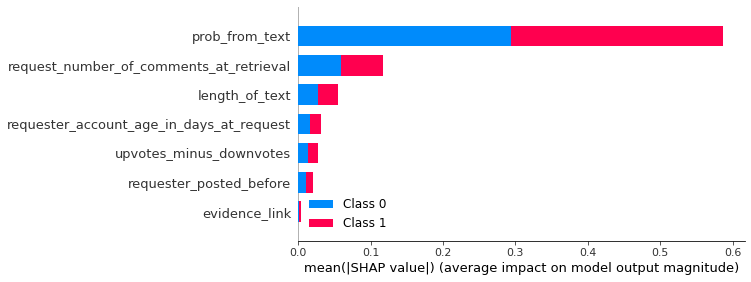

In [22]:
# using shapley values to understand importance of each feature
count_explainer = shap.TreeExplainer(new_final_count_rf_model_rf)
count_shap_values = count_explainer.shap_values(X_test)
shap.summary_plot(count_shap_values, X_test, plot_type="bar")

<BarContainer object of 7 artists>

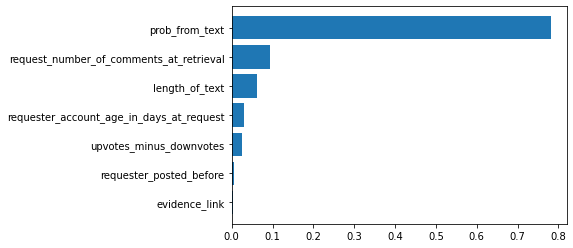

In [23]:
sorted_idx = new_final_count_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_count_rf_df.columns[sorted_idx], new_final_count_rf_model_rf.feature_importances_[sorted_idx])

In [24]:
test_count_df = new_count_vec.transform(test_set['final_request_text'])
print(test_count_df.shape)

(1134, 12776)


In [25]:
test_final_count_rf_df = final_test_set.copy()
test_count_rf_est_prob = new_count_model_rf.predict_proba(test_count_df)[:,1]
test_final_count_rf_df.insert(5,'prob_from_text',test_count_rf_est_prob)
test_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,0.179737,1,0
1,6,345.616910,7,414,1,0.231936,0,0
2,7,12.883854,4,730,0,0.318074,0,1
3,1,79.986516,1,387,0,0.206315,0,0
4,1,796.983414,0,322,0,0.252516,0,0
...,...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0.185152,0,0
1130,0,78.204560,0,475,0,0.314404,0,0
1131,3,75.020139,9,1211,0,0.376542,0,1
1132,6,330.132280,6,551,0,0.302290,0,0


In [26]:
test_final_count_rf_df = test_final_count_rf_df.sample(frac=1).reset_index(drop=True)
test_final_count_rf_labels = test_final_count_rf_df.iloc[:,-1]
test_final_count_rf_df = test_final_count_rf_df.iloc[:,:-1]
test_final_count_rf_labels

0       0
1       0
2       0
3       1
4       0
       ..
1129    0
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [27]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df))],
    ['Random Forest', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7151675485008818,0.4171597633136095,0.5280898876404494,0.4661157024793388
Gaussian NB,0.6948853615520282,0.3696369636963696,0.41947565543071164,0.39298245614035093
Random Forest,0.7469135802469136,0.4583333333333333,0.41198501872659177,0.43392504930966463


## Random Forest based TF-IDF Model

In [28]:
new_tfidf_vec = TfidfVectorizer(analyzer=process_text)
new_tfidf_df = new_tfidf_vec.fit_transform(train_set['final_request_text'])

new_tfidf_labels = train_set['requester_received_pizza']

print(new_tfidf_df.shape)

(4537, 12776)


In [29]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 10, shuffle=True)
new_tfidf_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_tfidf_model_nbg = GaussianNB()
new_tfidf_model_nbm = MultinomialNB()
new_tfidf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_tfidf_model_lr_accuracy_score = []
new_tfidf_model_nbg_accuracy_score = []
new_tfidf_model_nbm_accuracy_score = []
new_tfidf_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_tfidf_df, new_tfidf_labels):
    X_train, X_test = new_tfidf_df[train_index], new_tfidf_df[test_index]
    y_train, y_test = new_tfidf_labels[train_index], new_tfidf_labels[test_index]
    
    new_tfidf_model_lr.fit(X_train,y_train)
    new_tfidf_model_lr_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_lr.predict(X_test)))

    new_tfidf_model_nbg.fit(X_train.toarray(),y_train)
    new_tfidf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbg.predict(X_test.toarray())))
    
    new_tfidf_model_nbm.fit(X_train,y_train)
    new_tfidf_model_nbm_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbm.predict(X_test)))
    
    new_tfidf_model_rf.fit(X_train,y_train)
    new_tfidf_model_rf_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_tfidf_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_tfidf_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_tfidf_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_tfidf_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.554990712917311
Gaussian NB,0.5150941836605692
Multinomial NB,0.7509364880240395
Random Forest,0.7509364880240395


In [30]:
new_final_tfidf_rf_df = final_train_set.copy()
new_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(new_tfidf_df)[:,1]
new_final_tfidf_rf_df.insert(5,'prob_from_text',new_tfidf_rf_est_prob)
new_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,3,238.726840,6,145,0,0.301942,0,1
1,1,0.000000,1,901,1,0.170651,0,0
2,0,1250.097998,0,179,0,0.128708,0,0
3,2,171.035521,4,260,0,0.143950,0,0
4,2,466.100787,0,393,0,0.196801,0,0
...,...,...,...,...,...,...,...,...
4532,4,235.738241,0,566,0,0.154036,0,0
4533,13,237.207674,7,575,0,0.174078,0,0
4534,2,0.000000,2,636,0,0.207020,0,0
4535,8,0.000000,3,625,0,0.325261,0,0


In [31]:
new_final_tfidf_rf_df = new_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
new_final_tfidf_rf_labels = new_final_tfidf_rf_df.iloc[:,-1]
new_final_tfidf_rf_df = new_final_tfidf_rf_df.iloc[:,:-1]
new_final_tfidf_rf_labels

0       0
1       0
2       1
3       1
4       0
       ..
4532    1
4533    1
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [32]:
new_skfold_final_tfidf_rf = StratifiedKFold(n_splits = 10, shuffle=True)
new_final_tfidf_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_final_tfidf_rf_model_nbg = GaussianNB()
new_final_tfidf_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_final_tfidf_rf_model_lr_accuracy_score = []
new_final_tfidf_rf_model_nbg_accuracy_score = []
new_final_tfidf_rf_model_rf_accuracy_score = []

new_final_tfidf_rf_model_lr_precision_score = []
new_final_tfidf_rf_model_nbg_precision_score = []
new_final_tfidf_rf_model_rf_precision_score = []

new_final_tfidf_rf_model_lr_recall_score = []
new_final_tfidf_rf_model_nbg_recall_score = []
new_final_tfidf_rf_model_rf_recall_score = []

new_final_tfidf_rf_model_lr_f1_score = []
new_final_tfidf_rf_model_nbg_f1_score = []
new_final_tfidf_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_tfidf_rf.split(new_final_tfidf_rf_df, new_final_tfidf_rf_labels):
    X_train, X_test = new_final_tfidf_rf_df.iloc[train_index,:], new_final_tfidf_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_tfidf_rf_labels[train_index], new_final_tfidf_rf_labels[test_index]
    
    new_final_tfidf_rf_model_lr.fit(X_train,y_train)
    new_final_tfidf_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    
    new_final_tfidf_rf_model_nbg.fit(X_train,y_train)
    new_final_tfidf_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    
    new_final_tfidf_rf_model_rf.fit(X_train,y_train)
    new_final_tfidf_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_tfidf_rf_model_lr_accuracy_score),mean(new_final_tfidf_rf_model_lr_precision_score),mean(new_final_tfidf_rf_model_lr_recall_score),mean(new_final_tfidf_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_tfidf_rf_model_nbg_accuracy_score),mean(new_final_tfidf_rf_model_nbg_precision_score),mean(new_final_tfidf_rf_model_nbg_recall_score),mean(new_final_tfidf_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_tfidf_rf_model_rf_accuracy_score),mean(new_final_tfidf_rf_model_rf_precision_score),mean(new_final_tfidf_rf_model_rf_recall_score),mean(new_final_tfidf_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9396062471433712,0.8381585659325922,0.94070796460177,0.8859904002795898
Gaussian NB,0.9446703814997423,0.8722510567589465,0.9123893805309734,0.8913635714515403
Random Forest,0.9691386838599255,0.9584090377312408,0.915929203539823,0.936357206450099


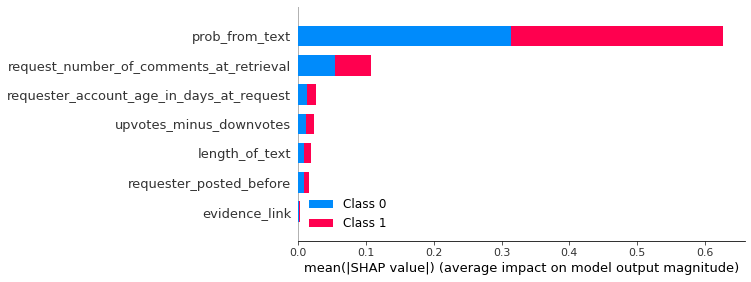

In [33]:
# using shapley values to understand importance of each feature
tfidf_explainer = shap.TreeExplainer(new_final_tfidf_rf_model_rf)
tfidf_shap_values = tfidf_explainer.shap_values(X_test)
shap.summary_plot(tfidf_shap_values, X_test, plot_type="bar")

<BarContainer object of 7 artists>

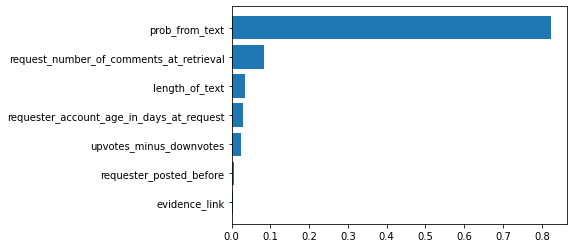

In [34]:
sorted_idx = new_final_tfidf_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_tfidf_rf_df.columns[sorted_idx], new_final_tfidf_rf_model_rf.feature_importances_[sorted_idx])

In [35]:
test_tfidf_df = new_tfidf_vec.transform(test_set['final_request_text'])
print(test_tfidf_df.shape)

(1134, 12776)


In [36]:
final_test_set

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,1,0
1,6,345.616910,7,414,1,0,0
2,7,12.883854,4,730,0,0,1
3,1,79.986516,1,387,0,0,0
4,1,796.983414,0,322,0,0,0
...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0,0
1130,0,78.204560,0,475,0,0,0
1131,3,75.020139,9,1211,0,0,1
1132,6,330.132280,6,551,0,0,0


In [37]:
test_final_tfidf_rf_df = final_test_set.copy()
test_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(test_tfidf_df)[:,1]
test_final_tfidf_rf_df.insert(5,'prob_from_text',test_tfidf_rf_est_prob)
test_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,0.189598,1,0
1,6,345.616910,7,414,1,0.261699,0,0
2,7,12.883854,4,730,0,0.289739,0,1
3,1,79.986516,1,387,0,0.232537,0,0
4,1,796.983414,0,322,0,0.264697,0,0
...,...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0.225720,0,0
1130,0,78.204560,0,475,0,0.317310,0,0
1131,3,75.020139,9,1211,0,0.314713,0,1
1132,6,330.132280,6,551,0,0.261383,0,0


In [38]:
test_final_tfidf_rf_df = test_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
test_final_tfidf_rf_labels = test_final_tfidf_rf_df.iloc[:,-1]
test_final_tfidf_rf_df = test_final_tfidf_rf_df.iloc[:,:-1]
test_final_tfidf_rf_labels

0       0
1       0
2       1
3       0
4       0
       ..
1129    0
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [39]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df))],
    ['Random Forest', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6684303350970018,0.3686746987951807,0.5730337078651685,0.44868035190615835
Gaussian NB,0.6701940035273368,0.34492753623188405,0.44569288389513106,0.3888888888888889
Random Forest,0.7680776014109347,0.5102040816326531,0.37453183520599254,0.4319654427645788


## Random Forest based MinMax Word2Vec Model

In [40]:
model = KeyedVectors.load_word2vec_format(PATH + "GoogleNews-vectors-negative300.bin", limit = 10**6,binary=True)

def get_vec(word):
    try:
        return model[word]
    except:
        return np.zeros(300)

def get_sent_vec_min_max(sent):
    tokens = process_text(sent)
    min_vector = np.min([get_vec(t) for t in tokens], axis = 0)
    max_vector = np.max([get_vec(t) for t in tokens], axis = 0)
    vector = np.concatenate([min_vector,max_vector])
    
    return vector

new_minmax_word2vec_emb = train_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
new_minmax_v = np.column_stack([new_minmax_word2vec_emb.values.tolist()])
new_minmax_word2vec_df = pd.DataFrame(new_minmax_v)
new_minmax_word2vec_labels = train_set['requester_received_pizza']
new_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.367188,-0.152344,-0.294922,-0.092285,-0.277344,-0.226562,-0.243164,-0.263672,-0.396484,-0.267578,...,0.062988,0.182617,0.096191,0.195312,0.546875,0.187500,0.210938,0.207031,0.161133,0.392578
1,-0.388672,-0.235352,-0.439453,-0.257812,-0.396484,-0.283203,-0.235352,-0.478516,-0.208008,-0.267578,...,0.310547,0.316406,0.180664,0.398438,0.546875,0.241211,0.373047,0.208008,0.326172,0.277344
2,-0.371094,-0.261719,-0.181641,-0.176758,-0.316406,-0.347656,-0.209961,-0.386719,-0.132812,-0.196289,...,0.265625,0.208984,0.043945,0.202148,0.546875,0.267578,0.184570,0.120605,0.255859,0.339844
3,-0.215820,-0.174805,-0.177734,-0.021484,-0.363281,-0.230469,-0.253906,-0.507812,-0.178711,-0.198242,...,0.320312,0.322266,0.043945,0.160156,0.369141,0.177734,0.196289,0.208008,0.322266,0.425781
4,-0.247070,-0.202148,-0.294922,-0.189453,-0.222656,-0.267578,-0.259766,-0.208984,-0.222656,-0.151367,...,0.365234,0.394531,0.277344,0.253906,0.546875,0.306641,0.210938,0.355469,0.378906,0.232422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4532,-0.435547,-0.371094,-0.294922,-0.092285,-0.326172,-0.294922,-0.241211,-0.361328,-0.240234,-0.402344,...,0.343750,0.376953,0.195312,0.398438,0.546875,0.277344,0.265625,0.208984,0.310547,0.281250
4533,-0.367188,-0.265625,-0.310547,-0.190430,-0.343750,-0.243164,-0.349609,-0.550781,-0.172852,-0.333984,...,0.223633,0.330078,0.116211,0.488281,0.546875,0.449219,0.265625,0.375000,0.220703,0.468750
4534,-0.412109,-0.168945,-0.310547,-0.273438,-0.527344,-0.184570,-0.236328,-0.443359,-0.143555,-0.363281,...,0.198242,0.408203,0.236328,0.335938,0.546875,0.449219,0.269531,0.375000,0.298828,0.392578
4535,-0.367188,-0.213867,-0.294922,-0.176758,-0.277344,-0.326172,-0.234375,-0.414062,-0.190430,-0.269531,...,0.273438,0.298828,0.219727,0.229492,0.546875,0.349609,0.308594,0.186523,0.273438,0.306641


In [41]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_minmax_word2vec = StratifiedKFold(n_splits = 10, shuffle=True)
new_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_minmax_word2vec_model_nbg = GaussianNB()
new_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_minmax_word2vec_model_lr_accuracy_score = []
new_minmax_word2vec_model_nbg_accuracy_score = []
new_minmax_word2vec_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_minmax_word2vec.split(new_minmax_word2vec_df, new_minmax_word2vec_labels):
    X_train, X_test = new_minmax_word2vec_df.iloc[train_index,:], new_minmax_word2vec_df.iloc[test_index,:]
    y_train, y_test = new_minmax_word2vec_labels[train_index], new_minmax_word2vec_labels[test_index]
    
    new_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_lr.predict(X_test)))
    
    new_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_minmax_word2vec_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_minmax_word2vec_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_minmax_word2vec_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.5243554959107662
Gaussian NB,0.5737370053777557
Random Forest,0.750715737472163


In [42]:
new_final_minmax_word2vec_rf_df = final_train_set.copy()
new_minmax_word2vec_rf_est_prob = new_minmax_word2vec_model_rf.predict_proba(new_minmax_word2vec_df)[:,1]
new_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',new_minmax_word2vec_rf_est_prob)

In [43]:
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
new_final_minmax_word2vec_rf_labels = new_final_minmax_word2vec_rf_df.iloc[:,-1]
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.iloc[:,:-1]
new_final_minmax_word2vec_rf_labels

0       1
1       0
2       0
3       0
4       1
       ..
4532    0
4533    0
4534    0
4535    1
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [44]:
new_skfold_final_minmax_word2vec = StratifiedKFold(n_splits = 10, shuffle=True)
new_final_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_final_minmax_word2vec_model_nbg = GaussianNB()
new_final_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_final_minmax_word2vec_model_lr_accuracy_score = []
new_final_minmax_word2vec_model_nbg_accuracy_score = []
new_final_minmax_word2vec_model_rf_accuracy_score = []

new_final_minmax_word2vec_model_lr_precision_score = []
new_final_minmax_word2vec_model_nbg_precision_score = []
new_final_minmax_word2vec_model_rf_precision_score = []

new_final_minmax_word2vec_model_lr_recall_score = []
new_final_minmax_word2vec_model_nbg_recall_score = []
new_final_minmax_word2vec_model_rf_recall_score = []

new_final_minmax_word2vec_model_lr_f1_score = []
new_final_minmax_word2vec_model_nbg_f1_score = []
new_final_minmax_word2vec_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_minmax_word2vec.split(new_final_minmax_word2vec_rf_df, new_final_minmax_word2vec_rf_labels):
    X_train, X_test = new_final_minmax_word2vec_rf_df.iloc[train_index,:], new_final_minmax_word2vec_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_minmax_word2vec_rf_labels[train_index], new_final_minmax_word2vec_rf_labels[test_index]
    
    new_final_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_final_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    
    new_final_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_final_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_final_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_final_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_minmax_word2vec_model_lr_accuracy_score),mean(new_final_minmax_word2vec_model_lr_precision_score),mean(new_final_minmax_word2vec_model_lr_recall_score),mean(new_final_minmax_word2vec_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_minmax_word2vec_model_nbg_accuracy_score),mean(new_final_minmax_word2vec_model_nbg_precision_score),mean(new_final_minmax_word2vec_model_nbg_recall_score),mean(new_final_minmax_word2vec_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_minmax_word2vec_model_rf_accuracy_score),mean(new_final_minmax_word2vec_model_rf_precision_score),mean(new_final_minmax_word2vec_model_rf_recall_score),mean(new_final_minmax_word2vec_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9647372873938793,0.9012220869650805,0.9654867256637167,0.9318490444082517
Gaussian NB,0.9676026684560104,0.9267536554065336,0.9451327433628318,0.9355855304587392
Random Forest,0.9748733358617537,0.9647008667553851,0.9336283185840708,0.9486723262505828


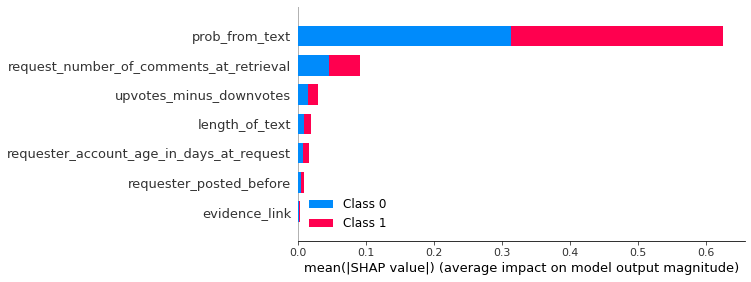

In [45]:
# using shapley values to understand importance of each feature
minmax_word2vec_explainer = shap.TreeExplainer(new_final_minmax_word2vec_model_rf)
minmax_word2vec_shap_values = minmax_word2vec_explainer.shap_values(X_test)
shap.summary_plot(minmax_word2vec_shap_values, X_test, plot_type="bar",show=False)
#plt.savefig('FeatureImportanceShapley.png',bbox_inches='tight')

<BarContainer object of 7 artists>

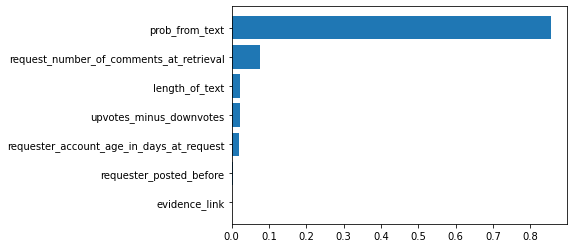

In [46]:
sorted_idx = new_final_minmax_word2vec_model_rf.feature_importances_.argsort()
plt.barh(new_final_minmax_word2vec_rf_df.columns[sorted_idx], new_final_minmax_word2vec_model_rf.feature_importances_[sorted_idx])

In [47]:
test_minmax_word2vec_emb = test_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
test_minmax_v = np.column_stack([test_minmax_word2vec_emb.values.tolist()])
test_minmax_word2vec_df = pd.DataFrame(test_minmax_v)
test_minmax_word2vec_labels = test_set['requester_received_pizza']
test_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.470703,-0.212891,-0.402344,-0.312500,-0.494141,-0.406250,-0.166016,-0.310547,-0.279297,-0.151367,...,0.207031,0.388672,0.238281,0.419922,0.546875,0.359375,0.188477,0.244141,0.289062,0.120117
1,-0.326172,-0.255859,-0.345703,-0.404297,-0.261719,-0.232422,-0.382812,-0.457031,-0.172852,-0.306641,...,0.332031,0.324219,0.146484,0.398438,0.546875,0.371094,0.232422,0.314453,0.310547,0.289062
2,-0.291016,-0.261719,-0.326172,-0.257812,-0.261719,-0.425781,-0.511719,-0.335938,-0.243164,-0.267578,...,0.273438,0.298828,0.251953,0.398438,0.546875,0.277344,0.234375,0.241211,0.478516,0.468750
3,-0.412109,-0.324219,-0.238281,-0.212891,-0.249023,-0.232422,-0.257812,-0.312500,-0.154297,-0.267578,...,0.332031,0.392578,0.107422,0.394531,0.369141,0.359375,0.394531,0.349609,0.273438,0.468750
4,-0.259766,-0.184570,-0.224609,-0.126953,-0.166992,-0.203125,-0.281250,-0.289062,-0.279297,-0.125977,...,0.296875,0.265625,0.060791,0.191406,0.546875,0.398438,0.223633,0.245117,0.242188,0.236328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,-0.455078,-0.263672,-0.333984,-0.166016,-0.259766,-0.326172,-0.150391,-0.265625,-0.210938,-0.267578,...,0.215820,0.296875,0.238281,0.419922,0.546875,0.277344,0.200195,0.207031,0.302734,0.079590
1130,-0.562500,-0.261719,-0.371094,-0.324219,-0.306641,-0.451172,-0.316406,-0.365234,-0.292969,-0.267578,...,0.206055,0.279297,0.251953,0.306641,0.546875,0.267578,0.215820,0.207031,0.324219,0.083496
1131,-0.291016,-0.263672,-0.310547,-0.384766,-0.241211,-0.425781,-0.511719,-0.441406,-0.236328,-0.162109,...,0.265625,0.376953,0.215820,0.453125,0.546875,0.404297,0.386719,0.271484,0.486328,0.322266
1132,-0.238281,-0.392578,-0.416016,-0.304688,-0.361328,-0.394531,-0.375000,-0.427734,-0.222656,-0.267578,...,0.310547,0.308594,0.219727,0.398438,0.281250,0.322266,0.291016,0.228516,0.449219,0.232422


In [48]:
test_final_minmax_word2vec_rf_df = final_test_set.copy()
test_tfidf_minmax_word2vec_est_prob = new_minmax_word2vec_model_rf.predict_proba(test_minmax_word2vec_df)[:,1]
test_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',test_tfidf_minmax_word2vec_est_prob)
test_final_minmax_word2vec_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,0.205650,1,0
1,6,345.616910,7,414,1,0.307345,0,0
2,7,12.883854,4,730,0,0.273446,0,1
3,1,79.986516,1,387,0,0.251695,0,0
4,1,796.983414,0,322,0,0.236723,0,0
...,...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0.276836,0,0
1130,0,78.204560,0,475,0,0.327401,0,0
1131,3,75.020139,9,1211,0,0.343220,0,1
1132,6,330.132280,6,551,0,0.253672,0,0


In [49]:
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
test_final_minmax_word2vec_rf_labels = test_final_minmax_word2vec_rf_df.iloc[:,-1]
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.iloc[:,:-1]
test_final_minmax_word2vec_rf_labels

0       1
1       0
2       0
3       0
4       1
       ..
1129    0
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [50]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df))],
    ['Random Forest', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6252204585537919,0.33541666666666664,0.602996254681648,0.43105756358768405
Gaussian NB,0.701058201058201,0.36363636363636365,0.3595505617977528,0.3615819209039548
Random Forest,0.7671957671957672,0.5079365079365079,0.3595505617977528,0.42105263157894735


## Random Forest based Doc2Vec 100 Model

In [51]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_100_model = Doc2Vec(vector_size=100, min_count=2, epochs = 50)

new_doc2vec_100_model.build_vocab(new_tagged_data)
new_doc2vec_100_model.train(new_tagged_data, epochs=new_doc2vec_100_model.epochs, total_examples=new_doc2vec_100_model.corpus_count)

new_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_100_df = pd.DataFrame(new_doc2vec_100_v)
new_doc2vec_100_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_100 = StratifiedKFold(n_splits = 10, shuffle=True)
new_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_doc2vec_100_model_nbg = GaussianNB()
new_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_doc2vec_100_model_lr_accuracy_score = []
new_doc2vec_100_model_nbg_accuracy_score = []
new_doc2vec_100_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_100.split(new_doc2vec_100_df, new_doc2vec_100_labels):
    X_train, X_test = new_doc2vec_100_df.iloc[train_index,:], new_doc2vec_100_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_100_labels[train_index], new_doc2vec_100_labels[test_index]
    
    new_doc2vec_100_model_lr.fit(X_train,y_train)
    new_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_lr.predict(X_test)))
    
    new_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_nbg.predict(X_test)))
    
    new_doc2vec_100_model_rf.fit(X_train,y_train)
    new_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_100_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_100_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_100_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.37712022639087434
Gaussian NB,0.6491038694557089
Random Forest,0.7496129571821727


In [52]:
new_final_doc2vec_100_rf_df = final_train_set.copy()
new_doc2vec_100_rf_est_prob = new_doc2vec_100_model_rf.predict_proba(new_doc2vec_100_df)[:,1]
new_final_doc2vec_100_rf_df.insert(5,'prob_from_text',new_doc2vec_100_rf_est_prob)

In [53]:
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_100_rf_labels = new_final_doc2vec_100_rf_df.iloc[:,-1]
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.iloc[:,:-1]
new_final_doc2vec_100_rf_labels

0       0
1       1
2       0
3       0
4       0
       ..
4532    0
4533    0
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [54]:
new_skfold_final_doc2vec_100 = StratifiedKFold(n_splits = 10,shuffle=True)
new_final_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_final_doc2vec_100_model_nbg = GaussianNB()
new_final_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_final_doc2vec_100_model_lr_accuracy_score = []
new_final_doc2vec_100_model_nbg_accuracy_score = []
new_final_doc2vec_100_model_rf_accuracy_score = []

new_final_doc2vec_100_model_lr_precision_score = []
new_final_doc2vec_100_model_nbg_precision_score = []
new_final_doc2vec_100_model_rf_precision_score = []

new_final_doc2vec_100_model_lr_recall_score = []
new_final_doc2vec_100_model_nbg_recall_score = []
new_final_doc2vec_100_model_rf_recall_score = []

new_final_doc2vec_100_model_lr_f1_score = []
new_final_doc2vec_100_model_nbg_f1_score = []
new_final_doc2vec_100_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_100.split(new_final_doc2vec_100_rf_df, new_final_doc2vec_100_rf_labels):
    X_train, X_test = new_final_doc2vec_100_rf_df.iloc[train_index,:], new_final_doc2vec_100_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_100_rf_labels[train_index], new_final_doc2vec_100_rf_labels[test_index]
    
    new_final_doc2vec_100_model_lr.fit(X_train,y_train)
    new_final_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    
    new_final_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))

    new_final_doc2vec_100_model_rf.fit(X_train,y_train)
    new_final_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_100_model_lr_accuracy_score),mean(new_final_doc2vec_100_model_lr_precision_score),mean(new_final_doc2vec_100_model_lr_recall_score),mean(new_final_doc2vec_100_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_100_model_nbg_accuracy_score),mean(new_final_doc2vec_100_model_nbg_precision_score),mean(new_final_doc2vec_100_model_nbg_recall_score),mean(new_final_doc2vec_100_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_100_model_rf_accuracy_score),mean(new_final_doc2vec_100_model_rf_precision_score),mean(new_final_doc2vec_100_model_rf_recall_score),mean(new_final_doc2vec_100_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9609859867160682,0.8911319312043082,0.9610619469026549,0.9246197319329054
Gaussian NB,0.9614270015851251,0.9044386074773786,0.9451327433628318,0.9241461740127563
Random Forest,0.9772981882895236,0.9741097615625918,0.9336283185840708,0.9533619292569699


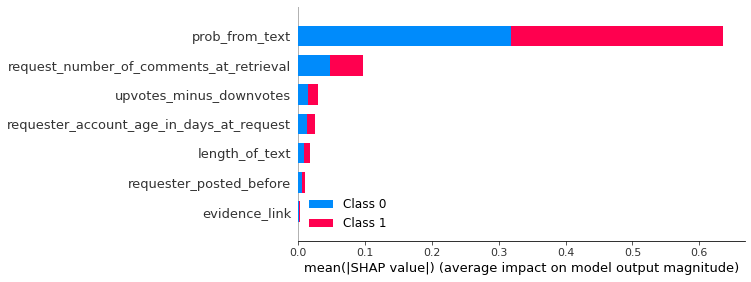

In [55]:
# using shapley values to understand importance of each feature
doc2vec_100_explainer = shap.TreeExplainer(new_final_doc2vec_100_model_rf)
doc2vec_100_shap_values = doc2vec_100_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_100_shap_values, X_test, plot_type="bar")

<BarContainer object of 7 artists>

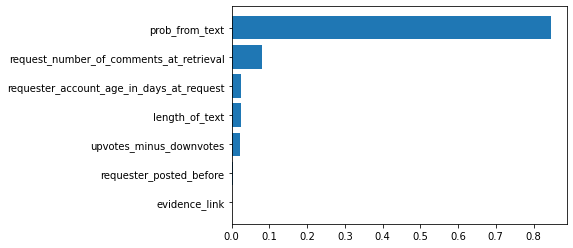

In [56]:
sorted_idx = new_final_doc2vec_100_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_100_rf_df.columns[sorted_idx], new_final_doc2vec_100_model_rf.feature_importances_[sorted_idx])

In [57]:
test_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_100_df = pd.DataFrame(test_doc2vec_100_v)

In [58]:
test_final_doc2vec_100_rf_df = final_test_set.copy()
test_tfidf_doc2vec_100_est_prob = new_doc2vec_100_model_rf.predict_proba(test_doc2vec_100_df)[:,1]
test_final_doc2vec_100_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_100_est_prob)
test_final_doc2vec_100_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,0.375141,1,0
1,6,345.616910,7,414,1,0.346610,0,0
2,7,12.883854,4,730,0,0.370339,0,1
3,1,79.986516,1,387,0,0.424011,0,0
4,1,796.983414,0,322,0,0.436158,0,0
...,...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0.388418,0,0
1130,0,78.204560,0,475,0,0.374011,0,0
1131,3,75.020139,9,1211,0,0.462429,0,1
1132,6,330.132280,6,551,0,0.403955,0,0


In [59]:
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_100_rf_labels = test_final_doc2vec_100_rf_df.iloc[:,-1]
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.iloc[:,:-1]
test_final_doc2vec_100_rf_labels

0       1
1       0
2       0
3       0
4       0
       ..
1129    0
1130    0
1131    0
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [60]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.4347442680776014,0.2713936430317848,0.8314606741573034,0.40921658986175113
Gaussian NB,0.5432098765432098,0.2965964343598055,0.6853932584269663,0.41402714932126694
Random Forest,0.7619047619047619,0.49238578680203043,0.36329588014981273,0.41810344827586204


## Random Forest based Doc2Vec 300 Model

In [61]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_300_model = Doc2Vec(vector_size=300, min_count=2, epochs = 50)

new_doc2vec_300_model.build_vocab(new_tagged_data)
new_doc2vec_300_model.train(new_tagged_data, epochs=new_doc2vec_300_model.epochs, total_examples=new_doc2vec_300_model.corpus_count)

new_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_300_df = pd.DataFrame(new_doc2vec_300_v)
new_doc2vec_300_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_300 = StratifiedKFold(n_splits = 10, shuffle=True)
new_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_doc2vec_300_model_nbg = GaussianNB()
new_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_doc2vec_300_model_lr_accuracy_score = []
new_doc2vec_300_model_nbg_accuracy_score = []
new_doc2vec_300_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_300.split(new_doc2vec_300_df, new_doc2vec_300_labels):
    X_train, X_test = new_doc2vec_300_df.iloc[train_index,:], new_doc2vec_300_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_300_labels[train_index], new_doc2vec_300_labels[test_index]
    
    new_doc2vec_300_model_lr.fit(X_train,y_train)
    new_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_lr.predict(X_test)))
    
    new_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_nbg.predict(X_test)))
    
    new_doc2vec_300_model_rf.fit(X_train,y_train)
    new_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_300_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_300_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_300_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.4500812011941924
Gaussian NB,0.6323530841866752
Random Forest,0.7507157374721631


In [62]:
new_final_doc2vec_300_rf_df = final_train_set.copy()
new_doc2vec_300_rf_est_prob = new_doc2vec_300_model_rf.predict_proba(new_doc2vec_300_df)[:,1]
new_final_doc2vec_300_rf_df.insert(5,'prob_from_text',new_doc2vec_300_rf_est_prob)

In [63]:
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_300_rf_labels = new_final_doc2vec_300_rf_df.iloc[:,-1]
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.iloc[:,:-1]
new_final_doc2vec_300_rf_labels

0       0
1       0
2       1
3       0
4       0
       ..
4532    0
4533    0
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [64]:
new_skfold_final_doc2vec_300 = StratifiedKFold(n_splits = 10, shuffle=True)
new_final_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5})
new_final_doc2vec_300_model_nbg = GaussianNB()
new_final_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

new_final_doc2vec_300_model_lr_accuracy_score = []
new_final_doc2vec_300_model_nbg_accuracy_score = []
new_final_doc2vec_300_model_rf_accuracy_score = []

new_final_doc2vec_300_model_lr_precision_score = []
new_final_doc2vec_300_model_nbg_precision_score = []
new_final_doc2vec_300_model_rf_precision_score = []

new_final_doc2vec_300_model_lr_recall_score = []
new_final_doc2vec_300_model_nbg_recall_score = []
new_final_doc2vec_300_model_rf_recall_score = []

new_final_doc2vec_300_model_lr_f1_score = []
new_final_doc2vec_300_model_nbg_f1_score = []
new_final_doc2vec_300_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_300.split(new_final_doc2vec_300_rf_df, new_final_doc2vec_300_rf_labels):
    X_train, X_test = new_final_doc2vec_300_rf_df.iloc[train_index,:], new_final_doc2vec_300_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_300_rf_labels[train_index], new_final_doc2vec_300_rf_labels[test_index]
    
    new_final_doc2vec_300_model_lr.fit(X_train,y_train)
    new_final_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    
    new_final_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))

    new_final_doc2vec_300_model_rf.fit(X_train,y_train)
    new_final_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_300_model_lr_accuracy_score),mean(new_final_doc2vec_300_model_lr_precision_score),mean(new_final_doc2vec_300_model_lr_recall_score),mean(new_final_doc2vec_300_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_300_model_nbg_accuracy_score),mean(new_final_doc2vec_300_model_nbg_precision_score),mean(new_final_doc2vec_300_model_nbg_recall_score),mean(new_final_doc2vec_300_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_300_model_rf_accuracy_score),mean(new_final_doc2vec_300_model_rf_precision_score),mean(new_final_doc2vec_300_model_rf_recall_score),mean(new_final_doc2vec_300_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9601034707432583,0.8882057048457007,0.9619469026548673,0.9233723325905432
Gaussian NB,0.960984041777285,0.9069740879318265,0.94070796460177,0.9233186111787064
Random Forest,0.9757543931304762,0.9724319217917563,0.9292035398230089,0.9502034984427579


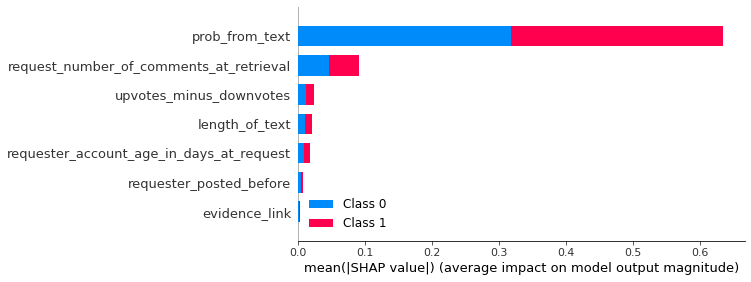

In [65]:
# using shapley values to understand importance of each feature
doc2vec_300_explainer = shap.TreeExplainer(new_final_doc2vec_300_model_rf)
doc2vec_300_shap_values = doc2vec_300_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_300_shap_values, X_test, plot_type="bar")

<BarContainer object of 7 artists>

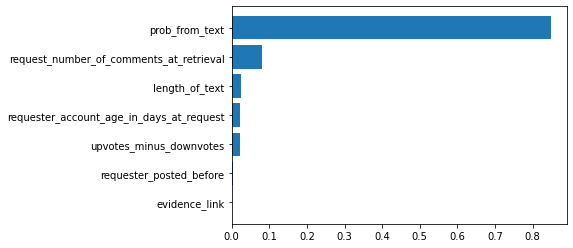

In [66]:
sorted_idx = new_final_doc2vec_300_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_300_rf_df.columns[sorted_idx], new_final_doc2vec_300_model_rf.feature_importances_[sorted_idx])

In [67]:
test_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_300_df = pd.DataFrame(test_doc2vec_300_v)

In [68]:
test_final_doc2vec_300_rf_df = final_test_set.copy()
test_tfidf_doc2vec_300_est_prob = new_doc2vec_300_model_rf.predict_proba(test_doc2vec_300_df)[:,1]
test_final_doc2vec_300_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_300_est_prob)
test_final_doc2vec_300_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,200.023310,1,500,0,0.360452,1,0
1,6,345.616910,7,414,1,0.399153,0,0
2,7,12.883854,4,730,0,0.385876,0,1
3,1,79.986516,1,387,0,0.459040,0,0
4,1,796.983414,0,322,0,0.521751,0,0
...,...,...,...,...,...,...,...,...
1129,1,0.000000,3,222,0,0.384181,0,0
1130,0,78.204560,0,475,0,0.366384,0,0
1131,3,75.020139,9,1211,0,0.483333,0,1
1132,6,330.132280,6,551,0,0.410169,0,0


In [69]:
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_300_rf_labels = test_final_doc2vec_300_rf_df.iloc[:,-1]
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.iloc[:,:-1]
test_final_doc2vec_300_rf_labels

0       0
1       1
2       0
3       1
4       0
       ..
1129    1
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [70]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.3977072310405644,0.26146788990825687,0.8539325842696629,0.40035118525021945
Gaussian NB,0.4911816578483245,0.2810734463276836,0.7453183520599251,0.4082051282051282
Random Forest,0.7451499118165785,0.45416666666666666,0.40823970037453183,0.42998027613412226


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


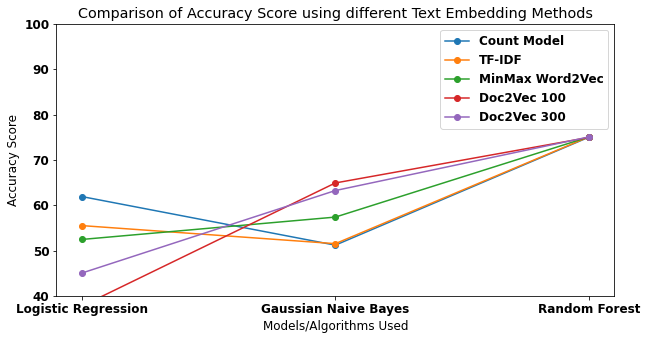

In [71]:
# Graphs for Text Models
text_accuracy_score = {'Count Model':[mean(new_count_model_lr_accuracy_score)*100,mean(new_count_model_nbg_accuracy_score)*100,mean(new_count_model_rf_accuracy_score)*100], 
                       'TF-IDF':[mean(new_tfidf_model_lr_accuracy_score)*100,mean(new_tfidf_model_nbg_accuracy_score)*100,mean(new_tfidf_model_rf_accuracy_score)*100],
                       'MinMax Word2Vec':[mean(new_minmax_word2vec_model_lr_accuracy_score)*100,mean(new_minmax_word2vec_model_nbg_accuracy_score)*100,mean(new_minmax_word2vec_model_rf_accuracy_score)*100],
                       'Doc2Vec 100':[mean(new_doc2vec_100_model_lr_accuracy_score)*100,mean(new_doc2vec_100_model_nbg_accuracy_score)*100,mean(new_doc2vec_100_model_rf_accuracy_score)*100],
                       'Doc2Vec 300':[mean(new_doc2vec_300_model_lr_accuracy_score)*100,mean(new_doc2vec_300_model_nbg_accuracy_score)*100,mean(new_doc2vec_300_model_rf_accuracy_score)*100]}
plot_data = pd.DataFrame(text_accuracy_score, index=['Logistic Regression','Gaussian Naive Bayes','Random Forest'])

fig = plt.figure(figsize=(10,5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.plot(plot_data.index,plot_data.loc[plot_data.index,:], marker = 'o')
plt.ylim(40,100)
plt.title('Comparison of Accuracy Score using different Text Embedding Methods')
plt.xlabel('Models/Algorithms Used')
plt.ylabel('Accuracy Score')
plt.legend(plot_data.columns)
plt.savefig('AccScoreTextModel.png', dpi=1200)
plt.show()

In [72]:
# testing performance

final_accuracy = pd.DataFrame({'Count Model':[
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_precision = pd.DataFrame({'Count Model':[
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_recall = pd.DataFrame({'Count Model':[
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_f1_score = pd.DataFrame({'Count Model':[
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc = pd.DataFrame({'Count Model':[
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict_proba(test_final_count_rf_df)[:, 1])
                         ], 
                         'TF-IDF':[
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict_proba(test_final_tfidf_rf_df)[:, 1])
                         ],
                         'Min-Max Doc2Vec':[
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1])
                         ],
                         'Doc2Vec 100':[
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict_proba(test_final_doc2vec_100_rf_df)[:, 1])
                         ],
                         'Doc2Vec 300':[
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict_proba(test_final_doc2vec_300_rf_df)[:, 1])
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,69.675449,69.818868,67.390243,65.120157,64.045808
Gaussian NB,68.528526,66.185434,64.896820,62.391518,63.761129
RF,72.013357,73.825538,76.421774,75.214373,72.708854


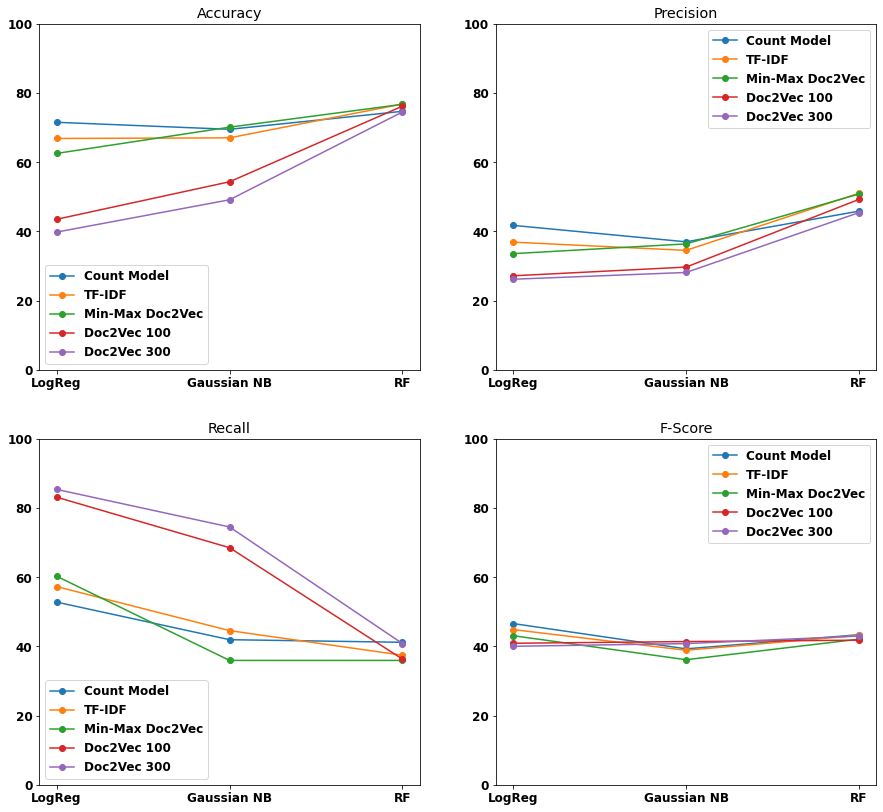

In [76]:
fig, ax = plt.subplots(2,2, figsize=(15,14))
ax[0][0].plot(final_accuracy.index,final_accuracy.loc[final_accuracy.index,:], marker = 'o')
ax[0][0].legend(final_accuracy.columns)
ax[0][0].set_ylim(0,100)
ax[0][0].set_title('Accuracy')
ax[0][1].plot(final_precision.index,final_precision.loc[final_precision.index,:], marker = 'o')
ax[0][1].legend(final_precision.columns)
ax[0][1].set_ylim(0,100)
ax[0][1].set_title('Precision')
ax[1][0].plot(final_recall.index,final_recall.loc[final_recall.index,:], marker = 'o')
ax[1][0].legend(final_recall.columns)
ax[1][0].set_ylim(0,100)
ax[1][0].set_title('Recall')
ax[1][1].plot(final_f1_score.index,final_f1_score.loc[final_f1_score.index,:], marker = 'o')
ax[1][1].legend(final_f1_score.columns)
ax[1][1].set_ylim(0,100)
ax[1][1].set_title('F-Score')
fig.show()
fig.savefig('Final_Model_Performance.png',dpi=1200, bbox_inches = 'tight')

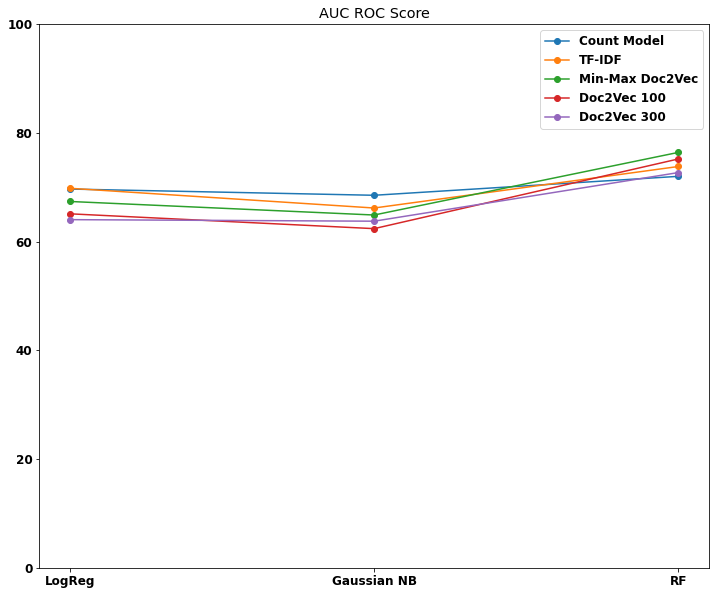

In [77]:
plt.figure(figsize = (12,10))
plt.plot(final_auc_roc.index,final_auc_roc.loc[final_auc_roc.index,:], marker = 'o')
plt.legend(final_auc_roc.columns)
plt.ylim(0,100)
plt.title('AUC ROC Score')
plt.savefig('Auc_Roc_Score_metric.png', dpi = 1200, bbox_inches = 'tight')
plt.show()